In [1]:
! pip install sentencepiece
! pip install transformers
! pip install rouge-score
! pip install datasets
! pip install transformers rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import requests
import io
import zipfile
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
import json
import re
import string
import html
import time
import torch
from rouge_score import rouge_scorer
from rouge import Rouge

# Load Dataset

In [ ]:
! pwd

/content


In [4]:
# download data
if not os.path.isdir("./nlp_data"):
  url = "https://cs.stanford.edu/~myasu/projects/scisumm_net/scisummnet_release1.1__20190413.zip"
  response = requests.get(url)
  with zipfile.ZipFile(io.BytesIO(response.content)) as zipObj:
     # Extract all the contents of zip file in different directory
     zipObj.extractall("nlp_data")
     print("File is unzipped in nlp_data folder") 
else:
  print("Data has been already downloaded.")

File is unzipped in nlp_data folder


In [5]:
# get all raw text, break all papers into two parts -- Abstract and rest of document
# first get all filepaths
xmlfiles = []
citations = []
summaries = []
for subdir, dirs, files in os.walk(r'./nlp_data/scisummnet_release1.1__20190413/top1000_complete'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".xml"):
            xmlfiles.append(filepath)
        if filepath.endswith(".json"):
            citations.append(filepath)
        if filepath.endswith(".txt"):
            summaries.append(filepath)

In [ ]:
print(summaries)

['./nlp_data/scisummnet_release1.1__20190413/top1000_complete/N03-2021/summary/N03-2021.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/C02-1144/summary/C02-1144.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/E87-1002/summary/E87-1002.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/P05-1044/summary/P05-1044.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/N13-1039/summary/N13-1039.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/P03-1012/summary/P03-1012.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/J04-1002/summary/J04-1002.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/W97-0209/summary/W97-0209.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/J93-1004/summary/J93-1004.gold.txt', './nlp_data/scisummnet_release1.1__20190413/top1000_complete/C92-1038/summary/C92-1038.gold.txt', './nlp_data/scisumm

In [6]:
#next parse all XML documents
def parse_xml_abstract(fp):
    """ parse an XML journal article into an abstract and the rest of the text
    """
    try:
        tree = ET.parse(fp)
    except Exception as e:
        return "","",str(e)
    root = tree.getroot()
    
    ab = []
    bod = []
    
    for child in root:
        if child.tag == "ABSTRACT":
            for block in child:
                ab.append(block.text)
        else:
            for block in child:
                bod.append(block.text)
                
    #convert from list --> string
    abstract = "\n".join(ab)
    body = "\n".join(bod)
    
    #decode html entities
    abstract = html.unescape(abstract)
    body = html.unescape(body)
    
    return abstract,body,""

In [7]:
# create DF with papers and citations

raw_cols = []
for fpn in range(len(xmlfiles)):
    ab,bod,err = parse_xml_abstract(xmlfiles[fpn])
    if err:
        #print(fp, err)
        continue
    f = open(citations[fpn]) 

    # returns JSON object as a dictionary 
    data = json.load(f) 
    only_text = []
    for entry in data:
        only_text.append(entry['clean_text'])
#     print(only_text)
        
    raw_cols.append([ab,bod,only_text,xmlfiles[fpn]])

df = pd.DataFrame(raw_cols, columns=["abstract","body","citations", "filepath"])
df.head()

,abstract,body,citations,filepath
0,Broad-coverage lexical resources such as WordN...,Broad-coverage lexical resources such as WordN...,"[Different measures have been proposed, which ...",./nlp_data/scisummnet_release1.1__20190413/top...
1,algebraic path problem (shortest paths; matrix...,Rational relations on strings have become wide...,[The calculation of expected counts can be for...,./nlp_data/scisummnet_release1.1__20190413/top...
2,This paper investigates why the HMMs es timate...,It is well known that Expectation-Maximization...,[[vbhmm]: Bayesian HMM with variational Bayes ...,./nlp_data/scisummnet_release1.1__20190413/top...
3,Identifying sentiments (the affective parts of...,What is an opinion?\nThe many opinions on opin...,[This idea is similar to that of (Kim and Hovy...,./nlp_data/scisummnet_release1.1__20190413/top...
4,,,"[Hence, the most important single construct of...",./nlp_data/scisummnet_release1.1__20190413/top...


In [8]:
# get all summary text using the summary path
summary_text = []
for fpn in range(len(summaries)):
    f = open(summaries[fpn]) 
    data = f.read()
    summary_text.append(data)

df['summary'] = summary_text

In [9]:
df.head()

,abstract,body,citations,filepath,summary
0,Broad-coverage lexical resources such as WordN...,Broad-coverage lexical resources such as WordN...,"[Different measures have been proposed, which ...",./nlp_data/scisummnet_release1.1__20190413/top...,Concept Discovery From Text\nBroad-coverage le...
1,algebraic path problem (shortest paths; matrix...,Rational relations on strings have become wide...,[The calculation of expected counts can be for...,./nlp_data/scisummnet_release1.1__20190413/top...,Parameter Estimation For Probabilistic Finite-...
2,This paper investigates why the HMMs es timate...,It is well known that Expectation-Maximization...,[[vbhmm]: Bayesian HMM with variational Bayes ...,./nlp_data/scisummnet_release1.1__20190413/top...,Why Doesn't EM Find Good HMM POS-Taggers?\nThi...
3,Identifying sentiments (the affective parts of...,What is an opinion?\nThe many opinions on opin...,[This idea is similar to that of (Kim and Hovy...,./nlp_data/scisummnet_release1.1__20190413/top...,Determining The Sentiment Of Opinions\nIdentif...
4,,,"[Hence, the most important single construct of...",./nlp_data/scisummnet_release1.1__20190413/top...,Japanese Discourse And The Process Of Centerin...


In [10]:
df.shape

(1009, 5)

In [34]:
# drop rows with missing values or empty abstract/body
df = df.dropna()
df = df[df.abstract != ""]
df = df[df.body != ""]

In [35]:
df.shape

(923, 5)

In [36]:
df.to_csv('scisumm.csv')

# EDA

<Axes: xlabel='variable', ylabel='value'>

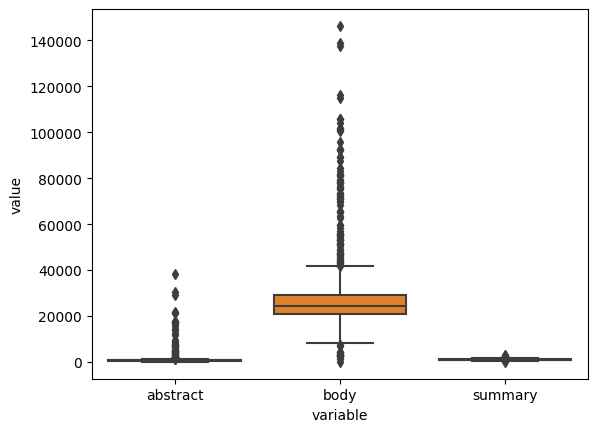

In [ ]:
# mean of length
import seaborn as sns
import matplotlib.pyplot as plt

data_statistics = {
    "abstract": [],
    "body": [],
    "summary": []
}

abstract_corpus = []
body_corpus = []
summary_corpus = []

for index, row in df.iterrows():
    data_statistics["abstract"].append(len(row["abstract"]))
    data_statistics["body"].append(len(row["body"]))
    data_statistics["summary"].append(len(row["summary"]))
    abstract_corpus.append(row["abstract"].lower())
    body_corpus.append(row["body"].lower())
    summary_corpus.append(row["summary"].lower())

df_statistics = pd.DataFrame(data_statistics)
sns.boxplot(x="variable", y="value", data=pd.melt(df_statistics))

In [ ]:
def avg_length(text_list):
    return round(sum(text_list)/len(text_list))

print("Average Abstract Length: {}".format(avg_length(data_statistics["abstract"])))
print("Average Body Length: {}".format(avg_length(data_statistics["body"])))
print("Average Golden Summary Length: {}".format(avg_length(data_statistics["summary"])))

Average Abstract Length: 1184
Average Body Length: 28019
Average Golden Summary Length: 1038


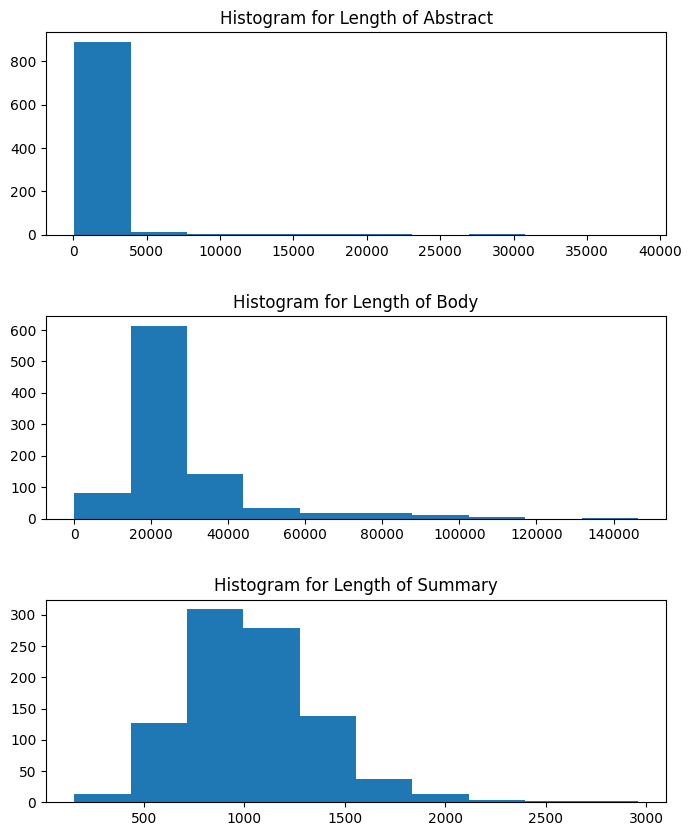

In [ ]:
# histogram 
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))
axs[0].hist(df["abstract"].str.len())
axs[1].hist(df["body"].str.len())
axs[2].hist(df["summary"].str.len())
axs[0].set_title('Histogram for Length of Abstract')
axs[1].set_title('Histogram for Length of Body')
axs[2].set_title('Histogram for Length of Summary')
plt.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
(pd.DataFrame(df["abstract"].str.len())).describe()

,abstract
count,924.000000
mean,1183.709957
std,2791.180703
min,79.000000
25%,524.000000
50%,685.500000
75%,892.000000
max,38470.000000


In [ ]:
(pd.DataFrame(df["body"].str.len())).describe()

,body
count,924.000000
mean,28018.755411
std,16925.680555
min,0.000000
25%,20683.250000
50%,24483.500000
75%,29145.750000
max,146332.000000


In [ ]:
(pd.DataFrame(df["summary"].str.len())).describe()

,summary
count,924.000000
mean,1037.645022
std,336.586696
min,154.000000
25%,805.000000
50%,1005.000000
75%,1230.500000
max,2958.000000


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

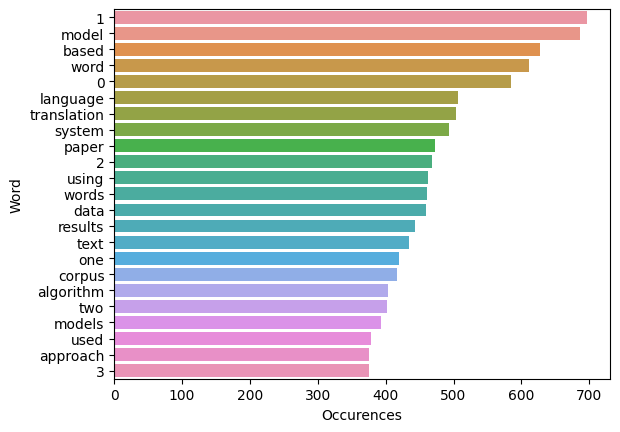

In [ ]:
# find most common words in abstracts
from collections import defaultdict, Counter
from nltk.corpus import stopwords

#create a set of english stopwords
stop_words = set(stopwords.words('english')) 

abstract_words = re.findall(r"[\w']+", "\n".join(abstract_corpus))
counter = Counter(abstract_words)
words_most = counter.most_common()
x, y = [], []
for word,count in words_most[:50]: # top 50 common words
    if (word not in stop_words):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.xlabel('Occurences')
plt.ylabel('Word')
plt.show()

# Pre-processing

In [2]:
df = pd.read_csv("./scisumm.csv", index_col=0)
df = df.reset_index(drop=True)
df.head()

,abstract,body,citations,filepath,summary
0,Broad-coverage lexical resources such as WordN...,Broad-coverage lexical resources such as WordN...,"['Different measures have been proposed, which...",./nlp_data/scisummnet_release1.1__20190413/top...,Concept Discovery From Text\nBroad-coverage le...
1,algebraic path problem (shortest paths; matrix...,Rational relations on strings have become wide...,['The calculation of expected counts can be fo...,./nlp_data/scisummnet_release1.1__20190413/top...,Parameter Estimation For Probabilistic Finite-...
2,This paper investigates why the HMMs es timate...,It is well known that Expectation-Maximization...,['[vbhmm]: Bayesian HMM with variational Bayes...,./nlp_data/scisummnet_release1.1__20190413/top...,Why Doesn't EM Find Good HMM POS-Taggers?\nThi...
3,Identifying sentiments (the affective parts of...,What is an opinion?\nThe many opinions on opin...,['This idea is similar to that of (Kim and Hov...,./nlp_data/scisummnet_release1.1__20190413/top...,Determining The Sentiment Of Opinions\nIdentif...
4,We investigate generalizations of the allsubtr...,The problem of bootstrapping syntactic structu...,['While Klein and Manning\'s approach may be d...,./nlp_data/scisummnet_release1.1__20190413/top...,An All-Subtrees Approach To Unsupervised Parsi...


In [3]:
df.shape

(923, 5)

In [39]:
df_clean = df.copy()

In [42]:
df_clean['body'] = df_clean['body'].astype(str)
print(df_clean['body'].dtype)

object


In [56]:
import re

# remove citations from the input text
cite_pattern = r"\(([\w\s]+(?:et al\.)?(?:,\s*[\w\s]+)*),?\s*\d{4}\)"
df_clean['body'] = df_clean['body'].apply(lambda x: re.sub(cite_pattern, '', x))

# remove texts enclosed in brackets
bracket_pattern = r"\(.*?\)"
df_clean['body'] = df_clean['body'].apply(lambda x: re.sub(bracket_pattern, '', x))

# remove unnecessary characters and symbols
df_clean['body'] = df_clean['body'].str.replace('[^a-zA-Z0-9\s]+', '')

# remove all \n and extra whitespaces
df_clean['body'] = df_clean['body'].apply(lambda x: x.replace('\n', ' ').strip())

In [74]:
df_clean['abstract'] = df_clean['abstract'].apply(lambda x: x.replace('\n', ' ').strip())
df_clean['summary'] = df_clean['summary'].apply(lambda x: x.replace('\n', ' ').strip())

In [78]:
df_clean.to_csv('scisumm_clean.csv')

# Model


In [15]:
df_clean = pd.read_csv("./scisumm_clean.csv", index_col=0)

In [3]:
df_clean.head()

,abstract,body,citations,filepath,summary
0,Broad-coverage lexical resources such as WordN...,Broadcoverage lexical resources such as WordNe...,"['Different measures have been proposed, which...",./nlp_data/scisummnet_release1.1__20190413/top...,Concept Discovery From Text Broad-coverage lex...
1,algebraic path problem (shortest paths; matrix...,Rational relations on strings have become wide...,['The calculation of expected counts can be fo...,./nlp_data/scisummnet_release1.1__20190413/top...,Parameter Estimation For Probabilistic Finite-...
2,This paper investigates why the HMMs es timate...,It is well known that ExpectationMaximization ...,['[vbhmm]: Bayesian HMM with variational Bayes...,./nlp_data/scisummnet_release1.1__20190413/top...,Why Doesn't EM Find Good HMM POS-Taggers? This...
3,Identifying sentiments (the affective parts of...,What is an opinion The many opinions on opinio...,['This idea is similar to that of (Kim and Hov...,./nlp_data/scisummnet_release1.1__20190413/top...,Determining The Sentiment Of Opinions Identify...
4,We investigate generalizations of the allsubtr...,The problem of bootstrapping syntactic structu...,['While Klein and Manning\'s approach may be d...,./nlp_data/scisummnet_release1.1__20190413/top...,An All-Subtrees Approach To Unsupervised Parsi...


In [16]:
df_clean.shape

(923, 5)

In [2]:
import torch
from transformers import T5TokenizerFast, T5ForConditionalGeneration
from transformers import Trainer, TrainingArguments
from transformers import LongformerTokenizerFast, EncoderDecoderModel

2023-04-21 02:44:25.169696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 02:44:26.301699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Split Dataset

In [5]:
# Train Test Split
from sklearn.model_selection import train_test_split

# split the data in 80:10:10 for train:valid:test dataset
# in_df = df_clean.sample(len(df_clean), random_state=630)
in_df = df.sample(len(df), random_state=630)
train_df, rem_df = train_test_split(in_df, train_size=0.8)
val_df, test_df = train_test_split(rem_df, test_size=0.5)

train_inputs = list(train_df['body'])
test_inputs = list(test_df['body'])
val_inputs = list(val_df['body'])
# val_input = [str(i) for i in val_df['body'].values]

train_targets = list(train_df['summary'])
test_targets = list(test_df['summary'])
val_targets = list(val_df['summary'])

In [20]:
def compute_rouge(rouge_scores):
    rouge_1_precision = np.mean([score['rouge-1']['p'] for score in rouge_scores])
    rouge_1_recall = np.mean([score['rouge-1']['r'] for score in rouge_scores])
    rouge_1_f1 = np.mean([score['rouge-1']['f'] for score in rouge_scores])
    
    rouge_2_precision = np.mean([score['rouge-2']['p'] for score in rouge_scores])
    rouge_2_recall = np.mean([score['rouge-2']['r'] for score in rouge_scores])
    rouge_2_f1 = np.mean([score['rouge-2']['f'] for score in rouge_scores])
    
    rouge_l_precision = np.mean([score['rouge-l']['p'] for score in rouge_scores])
    rouge_l_recall = np.mean([score['rouge-l']['r'] for score in rouge_scores])
    rouge_l_f1 = np.mean([score['rouge-l']['f'] for score in rouge_scores])
    
    return rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1

In [12]:
def generate_summaries(model, dataset, tokenizer):
    summaries = []
    model.eval()

    for item in dataset:
        with torch.no_grad():
            input_ids = item["input_ids"].unsqueeze(0).to(model.device)
            attention_mask = item["attention_mask"].unsqueeze(0).to(model.device)
            output = model.generate(input_ids, attention_mask=attention_mask)
            summary = tokenizer.decode(output[0], skip_special_tokens=True)
            summaries.append(summary)

    return summaries

## T5-small

In [8]:
model_name = 't5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
    
# Tokenize and encode dataset
train_inputs_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
train_targets_encodings = tokenizer(train_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_inputs_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_targets_encodings = tokenizer(val_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_inputs_encodings = tokenizer(test_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_targets_encodings = tokenizer(test_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')

class PrepareDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, decodings):
        self.encodings = encodings
        self.decodings = decodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
        item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = PrepareDataset(train_inputs_encodings, train_targets_encodings)
val_dataset = PrepareDataset(val_inputs_encodings, val_targets_encodings)
test_dataset = PrepareDataset(test_inputs_encodings, test_targets_encodings)

/home/wutongg/miniconda3/envs/si630/lib/python3.11/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### Fine-tuned

In [8]:
# Define the evaluation function with Rouge metrics
def compute_metrics(pred):
    targets = pred.label_ids
    preds = pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    for batch_idx in range(len(targets)): # 92 batches with 466 predictions
        batch_rouge1_scores = []
        batch_rouge2_scores = []
        batch_rougel_scores = []
        for pred_idx in range(len(targets[batch_idx])):
            target = tokenizer.decode(targets[batch_idx][pred_idx], skip_special_tokens=True)
            sequence_ids = (preds[batch_idx][pred_idx]).reshape((1, -1))
            # np.save('my_array.npy', sequence_ids)
            # sequence_ids_list = sequence_ids.tolist()
            # print(type(sequence_ids))
            # print(sequence_ids.shape)
            pred = tokenizer.batch_decode(np.abs(sequence_ids.astype(int)), skip_special_tokens=True)
            # print(pred)
            scores = scorer.score(target, "".join(pred))
            batch_rouge1_scores.append(scores['rouge1'].fmeasure)
            batch_rouge2_scores.append(scores['rouge2'].fmeasure)
            batch_rougel_scores.append(scores['rougeL'].fmeasure)
        rouge1_scores.append(sum(batch_rouge1_scores) / len(batch_rouge1_scores))
        rouge2_scores.append(sum(batch_rouge2_scores) / len(batch_rouge2_scores))
        rougel_scores.append(sum(batch_rougel_scores) / len(batch_rougel_scores))
    rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    rougel_score = sum(rougel_scores) / len(rougel_scores)
    return {'rouge1': rouge1_score, 'rouge2': rouge2_score, 'rougeL': rougel_score}

In [12]:
# Fine-tune T5 model
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=100,
    weight_decay=1e-4,
    logging_dir='./logs',
    save_strategy='epoch',
    logging_steps=100,
    load_best_model_at_end=True
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    # compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model()

/home/wutongg/miniconda3/envs/si630/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_475737/3811750581.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_475737/3811750581.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_475737/3811750581.py:21: UserWarnin

Epoch,Training Loss,Validation Loss
1,6.851900,1.912566
2,1.508600,1.847081
3,1.408700,1.816899
4,1.366000,1.805662
5,1.411300,1.802363


/tmp/ipykernel_475737/3811750581.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_475737/3811750581.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_475737/3811750581.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
/tmp/ipykernel_475737/3811750581.py:19: UserWarning: To copy 

In [13]:
test_summaries = generate_summaries(model, test_dataset, tokenizer)

/tmp/ipykernel_475737/3811750581.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_475737/3811750581.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_475737/3811750581.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
/home/wutongg/miniconda3/envs/si630/lib/python3.11/site-packa

In [14]:
from rouge import Rouge

rouge_scores = []
rouge = Rouge()

for gen_summary, ref_summary in zip(test_summaries, test_df['summary']):
    scores = rouge.get_scores(ref_summary, gen_summary)[0]
    rouge_scores.append(scores)

rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1 = compute_rouge(rouge_scores)

print(f"ROUGE-1 Precision: {rouge_1_precision:.4f}, Recall: {rouge_1_recall:.4f}, F1: {rouge_1_f1:.4f}")
print(f"ROUGE-2 Precision: {rouge_2_precision:.4f}, Recall: {rouge_2_recall:.4f}, F1: {rouge_2_f1:.4f}")
print(f"ROUGE-L Precision: {rouge_l_precision:.4f}, Recall: {rouge_l_recall:.4f}, F1: {rouge_l_f1:.4f}")

ROUGE-1 Precision: 0.0738, Recall: 0.5628, F1: 0.1291
ROUGE-2 Precision: 0.0204, Recall: 0.2204, F1: 0.0370
ROUGE-L Precision: 0.0698, Recall: 0.5344, F1: 0.1222


### No tuning

In [11]:
rouge = Rouge()
rouge_scores = []

for i, row in test_df.iterrows():
    body = row['body']
    summary = row['summary']

    # Encode the input text
    input_ids = tokenizer.encode(body, max_length=512, padding='max_length', truncation=True, return_tensors='pt')

    # Generate the summary using the T5 model
    summary_ids = model.generate(input_ids, max_length=150, num_beams=2, early_stopping=True)
    predicted_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    score = rouge.get_scores(predicted_summary, summary, avg=True)
    rouge_scores.append(score)

rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1 = compute_rouge(rouge_scores)

print(f"ROUGE-1 Precision: {rouge_1_precision:.4f}, Recall: {rouge_1_recall:.4f}, F1: {rouge_1_f1:.4f}")
print(f"ROUGE-2 Precision: {rouge_2_precision:.4f}, Recall: {rouge_2_recall:.4f}, F1: {rouge_2_f1:.4f}")
print(f"ROUGE-L Precision: {rouge_l_precision:.4f}, Recall: {rouge_l_recall:.4f}, F1: {rouge_l_f1:.4f}")

ROUGE-1 Precision: 0.3920, Recall: 0.1354, F1: 0.1956
ROUGE-2 Precision: 0.1315, Recall: 0.0351, F1: 0.0535
ROUGE-L Precision: 0.3658, Recall: 0.1254, F1: 0.1814


## T5+extractive
### n=20

In [3]:
train_df_ex = pd.read_csv("./train_df.csv", index_col=0)
val_df_ex = pd.read_csv("./val_df.csv", index_col=0)
test_df_ex = pd.read_csv("./test_df.csv", index_col=0)

In [4]:
train_df_ex.head()

,Unnamed: 0,abstract,body,citations,filepath,summary,body_extractive
234,264,Large-scale natural language generation requir...,A large-scale natural language generation (NLG...,['Some NLG techniques use sampling strategies ...,/home/xinye/nlp_data/scisummnet_release1.1__20...,Two-Level Many-Paths Generation\nLarge-scale n...,The quality of an NLG system depends on the qu...
865,946,This paper compares a number of generative pro...,The currently best single-model statistical pa...,['These parsers are trained and evaluated usin...,/home/xinye/nlp_data/scisummnet_release1.1__20...,Generative Models For Statistical Parsing With...,CCG grammars are characterized by much larger ...
472,525,Most foreign names are transliterated into Chi...,In applications such as cross-lingual informat...,['(Li et al 2004) introduced the joint transli...,/home/xinye/nlp_data/scisummnet_release1.1__20...,A Joint Source-Channel Model For Machine Trans...,"For writing foreign names in Chinese, translit..."
160,183,Unsupervised learning of linguistic structure ...,Unsupervised learning of linguistic structure ...,"['The application of MCMC techniques, includin...",/home/xinye/nlp_data/scisummnet_release1.1__20...,A fully Bayesian approach to unsupervised part...,"First, integrating over parameter values leads..."
79,91,By exploring the relationship between parsing ...,The aim of this paper is to explore the relati...,"['such as Earley deduction, to coestruct a par...",/home/xinye/nlp_data/scisummnet_release1.1__20...,Parsing As Deduction\nBy exploring the relatio...,This identification can then be generalized to...


In [5]:
train_df_ex = train_df_ex.dropna()
val_df_ex = val_df_ex.dropna()
test_df_ex = test_df_ex.dropna()

In [6]:
train_inputs = list(train_df_ex['body_extractive'])
test_inputs = list(test_df_ex['body_extractive'])
val_inputs = list(val_df_ex['body_extractive'])
# val_input = [str(i) for i in val_df['body'].values]

train_targets = list(train_df_ex['summary'])
test_targets = list(test_df_ex['summary'])
val_targets = list(val_df_ex['summary'])

In [7]:
model_name = 't5-small'
tokenizer = T5TokenizerFast.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

train_inputs_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
train_targets_encodings = tokenizer(train_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_inputs_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_targets_encodings = tokenizer(val_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_inputs_encodings = tokenizer(test_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_targets_encodings = tokenizer(test_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')

class PrepareDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, decodings):
        self.encodings = encodings
        self.decodings = decodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
        item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = PrepareDataset(train_inputs_encodings, train_targets_encodings)
val_dataset = PrepareDataset(val_inputs_encodings, val_targets_encodings)
test_dataset = PrepareDataset(test_inputs_encodings, test_targets_encodings)

# Define the evaluation function with Rouge metrics
def compute_metrics(pred):
    targets = pred.label_ids
    preds = pred.predictions
    if isinstance(preds, tuple):
        preds = preds[0]
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    for batch_idx in range(len(targets)): # 92 batches with 466 predictions
        batch_rouge1_scores = []
        batch_rouge2_scores = []
        batch_rougel_scores = []
        for pred_idx in range(len(targets[batch_idx])):
            target = tokenizer.decode(targets[batch_idx][pred_idx], skip_special_tokens=True)
            sequence_ids = (preds[batch_idx][pred_idx]).reshape((1, -1))
            # np.save('my_array.npy', sequence_ids)
            # sequence_ids_list = sequence_ids.tolist()
            # print(type(sequence_ids))
            # print(sequence_ids.shape)
            pred = tokenizer.batch_decode(np.abs(sequence_ids.astype(int)), skip_special_tokens=True)
            # print(pred)
            scores = scorer.score(target, "".join(pred))
            batch_rouge1_scores.append(scores['rouge1'].fmeasure)
            batch_rouge2_scores.append(scores['rouge2'].fmeasure)
            batch_rougel_scores.append(scores['rougeL'].fmeasure)
        rouge1_scores.append(sum(batch_rouge1_scores) / len(batch_rouge1_scores))
        rouge2_scores.append(sum(batch_rouge2_scores) / len(batch_rouge2_scores))
        rougel_scores.append(sum(batch_rougel_scores) / len(batch_rougel_scores))
    rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    rougel_score = sum(rougel_scores) / len(rougel_scores)
    return {'rouge1': rouge1_score, 'rouge2': rouge2_score, 'rougeL': rougel_score}

/home/wutongg/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [8]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy='epoch',
    logging_steps=100,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    # compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model()

/home/wutongg/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_445123/332034878.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_445123/332034878.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_445123/332034878.py:20: UserWarning: To copy construc

Epoch,Training Loss,Validation Loss
1,1.504100,1.551666
2,1.505100,1.512209
3,1.469200,1.495713
4,1.471500,1.488386
5,1.358100,1.487324


/tmp/ipykernel_445123/332034878.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_445123/332034878.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_445123/332034878.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
/tmp/ipykernel_445123/332034878.py:18: UserWarning: To copy cons

In [9]:
test_summaries = generate_summaries(model, test_dataset, tokenizer)

/tmp/ipykernel_445123/332034878.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_445123/332034878.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_445123/332034878.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
/home/wutongg/.local/lib/python3.9/site-packages/transformers/ge

In [14]:
rouge_scores = []
rouge = Rouge()

for gen_summary, ref_summary in zip(test_summaries, test_df_ex['summary']):
    scores = rouge.get_scores(ref_summary, gen_summary)[0]
    rouge_scores.append(scores)

rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1 = compute_rouge(rouge_scores)

print(f"ROUGE-1 Precision: {rouge_1_precision:.4f}, Recall: {rouge_1_recall:.4f}, F1: {rouge_1_f1:.4f}")
print(f"ROUGE-2 Precision: {rouge_2_precision:.4f}, Recall: {rouge_2_recall:.4f}, F1: {rouge_2_f1:.4f}")
print(f"ROUGE-L Precision: {rouge_l_precision:.4f}, Recall: {rouge_l_recall:.4f}, F1: {rouge_l_f1:.4f}")

ROUGE-1 Precision: 0.0613, Recall: 0.5086, F1: 0.1081
ROUGE-2 Precision: 0.0129, Recall: 0.1510, F1: 0.0235
ROUGE-L Precision: 0.0580, Recall: 0.4801, F1: 0.1023


## LED - Longformer

In [7]:
from transformers import LEDForConditionalGeneration, LEDTokenizerFast

model_name = 'allenai/led-base-16384'
tokenizer = LEDTokenizerFast.from_pretrained(model_name) 
model = LEDForConditionalGeneration.from_pretrained(model_name)

### LED+extractive

In [16]:
train_inputs_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
train_targets_encodings = tokenizer(train_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_inputs_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_targets_encodings = tokenizer(val_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_inputs_encodings = tokenizer(test_inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')
test_targets_encodings = tokenizer(test_targets, padding=True, truncation=True, max_length=512, return_tensors='pt')

class PrepareDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, decodings):
        self.encodings = encodings
        self.decodings = decodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
        item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = PrepareDataset(train_inputs_encodings, train_targets_encodings)
val_dataset = PrepareDataset(val_inputs_encodings, val_targets_encodings)
test_dataset = PrepareDataset(test_inputs_encodings, test_targets_encodings)

In [18]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=10,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    # compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

/tmp/ipykernel_483601/508937258.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_483601/508937258.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_483601/508937258.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])


Epoch,Training Loss,Validation Loss
1,1.084900,1.278121
2,0.905300,1.242675
3,1.048300,1.242003


/tmp/ipykernel_483601/508937258.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_483601/508937258.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_483601/508937258.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
/tmp/ipykernel_483601/508937258.py:14: UserWarning: To copy cons

TrainOutput(global_step=2214, training_loss=1.28779417981731, metrics={'train_runtime': 399.1466, 'train_samples_per_second': 5.547, 'train_steps_per_second': 5.547, 'total_flos': 747281688035328.0, 'train_loss': 1.28779417981731, 'epoch': 3.0})

In [21]:
test_summaries = generate_summaries(model, test_dataset, tokenizer)

rouge_scores = []
rouge = Rouge()

for gen_summary, ref_summary in zip(test_summaries, test_df_ex['summary']):
    scores = rouge.get_scores(ref_summary, gen_summary)[0]
    rouge_scores.append(scores)

rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1 = compute_rouge(rouge_scores)

print(f"ROUGE-1 Precision: {rouge_1_precision:.4f}, Recall: {rouge_1_recall:.4f}, F1: {rouge_1_f1:.4f}")
print(f"ROUGE-2 Precision: {rouge_2_precision:.4f}, Recall: {rouge_2_recall:.4f}, F1: {rouge_2_f1:.4f}")
print(f"ROUGE-L Precision: {rouge_l_precision:.4f}, Recall: {rouge_l_recall:.4f}, F1: {rouge_l_f1:.4f}")

/tmp/ipykernel_483601/508937258.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_483601/508937258.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_483601/508937258.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])


ROUGE-1 Precision: 0.0565, Recall: 0.4666, F1: 0.1000
ROUGE-2 Precision: 0.0151, Recall: 0.1715, F1: 0.0274
ROUGE-L Precision: 0.0538, Recall: 0.4443, F1: 0.0952


### No tuning

In [9]:
# Define a function to generate summaries using the LED model and tokenizer
def generate_summary(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    global_attention_mask = torch.zeros_like(input_ids)
    global_attention_mask[:, 0] = 1

    summary_ids = model.generate(input_ids, global_attention_mask=global_attention_mask,
                                 num_beams=4)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return summary

# Generate summaries for the test dataset
df_led = test_df.copy()
df_led['predicted_summary'] = test_df['body'].apply(generate_summary)

# Calculate ROUGE scores using the rouge_scorer library
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

total_scores = {'rouge1': {'f': 0, 'p': 0, 'r': 0},
                    'rouge2': {'f': 0, 'p': 0, 'r': 0},
                    'rougeL': {'f': 0, 'p': 0, 'r': 0}}

num_examples = len(df_led)
for i in range(num_examples):
    body = df_led.iloc[i]['body']
    summary = df_led.iloc[i]['predicted_summary']
    scores = scorer.score(summary, body)
    for metric in scores.keys():
        total_scores[metric]['f'] += scores[metric].fmeasure
        total_scores[metric]['p'] += scores[metric].precision
        total_scores[metric]['r'] += scores[metric].recall

    # Calculate average scores
    for metric in total_scores.keys():
        total_scores[metric]['f'] /= num_examples
        total_scores[metric]['p'] /= num_examples
        total_scores[metric]['r'] /= num_examples

total_scores

/home/wutongg/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'rouge1': {'f': 0.0006304267919044219,
  'p': 0.0003247107198005115,
  'r': 0.010869476415315325},
 'rouge2': {'f': 0.0005845668680734572,
  'p': 0.00030043135621817365,
  'r': 0.010869468798029152},
 'rougeL': {'f': 0.0006304267919044219,
  'p': 0.0003247107198005115,
  'r': 0.010869476415315325}}

### Fine-tuned

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, body_list, summary_list, tokenizer):
        self.body_list = body_list
        self.summary_list = summary_list
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.body_list)

    def __getitem__(self, idx):
        body = self.body_list[idx]
        summary = self.summary_list[idx]

        encoding = self.tokenizer(body, max_length=1024, padding='max_length', truncation=True, return_tensors='pt')
        summary_encoding = self.tokenizer(summary, max_length=256, padding='max_length', truncation=True, return_tensors='pt')

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        decoder_input_ids = summary_encoding['input_ids'].squeeze()
        decoder_attention_mask = summary_encoding['attention_mask'].squeeze()
        labels = decoder_input_ids.clone()

        # Set the first token of the decoder input and labels to the summary start token
        decoder_input_ids[0] = self.tokenizer.bos_token_id
        labels[labels == self.tokenizer.pad_token_id] = -100

        return input_ids, attention_mask, decoder_input_ids, decoder_attention_mask, labels

# Define training and validation datasets
train_dataset = MyDataset(train_inputs, train_targets, tokenizer)
val_dataset = MyDataset(val_inputs, val_targets, tokenizer)
test_dataset = MyDataset(test_inputs, test_targets, tokenizer)

In [13]:
# do not use!!
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    rouge_scores = rouge.get_scores(decoded_preds, decoded_labels, avg=True)
    return rouge_scores
    

In [11]:
def compute_metrics(pred):
    preds, targets = pred
    if isinstance(preds, tuple):
        preds = preds[0]
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []

    for batch_idx in range(len(targets)): # 92 batches with 466 predictions
        batch_rouge1_scores = []
        batch_rouge2_scores = []
        batch_rougel_scores = []
        for pred_idx in range(len(targets[batch_idx])):
            target = tokenizer.batch_decode(targets[batch_idx][pred_idx], skip_special_tokens=True)
            sequence_ids = (preds[batch_idx][pred_idx]).reshape((1, -1))
            # np.save('my_array.npy', sequence_ids)
            # sequence_ids_list = sequence_ids.tolist()
            # print(type(sequence_ids))
            # print(sequence_ids.shape)
            pred = tokenizer.batch_decode(np.abs(sequence_ids.astype(int)), skip_special_tokens=True)
            # print(pred)
            scores = scorer.score(target, "".join(pred))
            batch_rouge1_scores.append(scores['rouge1'].fmeasure)
            batch_rouge2_scores.append(scores['rouge2'].fmeasure)
            batch_rougel_scores.append(scores['rougeL'].fmeasure)
        rouge1_scores.append(sum(batch_rouge1_scores) / len(batch_rouge1_scores))
        rouge2_scores.append(sum(batch_rouge2_scores) / len(batch_rouge2_scores))
        rougel_scores.append(sum(batch_rougel_scores) / len(batch_rougel_scores))
    rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    rougel_score = sum(rougel_scores) / len(rougel_scores)
    return {'rouge1': rouge1_score, 'rouge2': rouge2_score, 'rougeL': rougel_score}

In [14]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=10,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                'attention_mask': torch.stack([f[1] for f in data]),
                                'decoder_input_ids': torch.stack([f[2] for f in data]),
                                'decoder_attention_mask': torch.stack([f[3] for f in data]),
                                'labels': torch.stack([f[4] for f in data])},
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

/home/wutongg/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.92 GiB (GPU 0; 15.78 GiB total capacity; 9.60 GiB already allocated; 1.23 GiB free; 13.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
def compute_rouge(rouge_scores):
    rouge_1_precision = np.mean([score['rouge-1']['p'] for score in rouge_scores])
    rouge_1_recall = np.mean([score['rouge-1']['r'] for score in rouge_scores])
    rouge_1_f1 = np.mean([score['rouge-1']['f'] for score in rouge_scores])
    
    rouge_2_precision = np.mean([score['rouge-2']['p'] for score in rouge_scores])
    rouge_2_recall = np.mean([score['rouge-2']['r'] for score in rouge_scores])
    rouge_2_f1 = np.mean([score['rouge-2']['f'] for score in rouge_scores])
    
    rouge_l_precision = np.mean([score['rouge-l']['p'] for score in rouge_scores])
    rouge_l_recall = np.mean([score['rouge-l']['r'] for score in rouge_scores])
    rouge_l_f1 = np.mean([score['rouge-l']['f'] for score in rouge_scores])
    
    return rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1

test_pred = trainer.predict(test_dataset)
decoded_preds = [tokenizer.decode(pred, skip_special_tokens=True) for pred in test_pred.predictions]
references = [example['summary'] for example in test_dataset]

rouge_scores = scorer.score(decoded_preds, references)
rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1 = compute_rouge(rouge_scores)

print(f"ROUGE-1 Precision: {rouge_1_precision:.4f}, Recall: {rouge_1_recall:.4f}, F1: {rouge_1_f1:.4f}")
print(f"ROUGE-2 Precision: {rouge_2_precision:.4f}, Recall: {rouge_2_recall:.4f}, F1: {rouge_2_f1:.4f}")
print(f"ROUGE-L Precision: {rouge_l_precision:.4f}, Recall: {rouge_l_recall:.4f}, F1: {rouge_l_f1:.4f}")

#  Pegasus model 
The Pegasus model was proposed in [PEGASUS][1]: Pre-training with Extracted Gap-sentences for Abstractive Summarization by Jingqing Zhang, Yao Zhao, Mohammad Saleh and Peter J. Liu on Dec 18, 2019.  

Pegasus’ pretraining task is intentionally similar to summarization: important sentences are removed/masked from an input document and are generated together as one output sequence from the remaining sentences, similar to an extractive summary.

[1]: https://huggingface.co/docs/transformers/model_doc/pegasus

In [22]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

model_name = 'google/pegasus-arxiv'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

In [ ]:
# df.reset_index(drop=True, inplace=True)

In [ ]:
# sample with no fine-tunning
sample_input = df.body[0]
inputs = tokenizer([sample_input], max_length=1024, return_tensors='pt')

# batch = tokenizer(sample_input, truncation=True, padding='longest', return_tensors="pt").to(torch_device)
summary_ids = model.generate(inputs['input_ids']) # generate summary
sample_output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
print(sample_output)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['clustering algorithms are very useful in many applications . <n> however , clustering algorithms can be very difficult to implement in practice . <n> we propose a new method of clustering that is based on the following three ideas . <n> first , we introduce a new clustering algorithm that is based on the following three ideas . <n> first , we introduce a new method of clustering that is based on the following three ideas . <n> second , we introduce a new method of clustering that is based on the following three ideas . <n> third , we introduce a new method of clustering that is based on the following three ideas . <n> fourth , we introduce a new method of clustering that is based on the following three ideas . <n> fifth , we introduce a new method of clustering that is based on the following three ideas . <n> sixth , we introduce a new method of clustering that is based on the following three ideas . <n> seventh , we introduce a new method of clustering that is based on the following

In [ ]:
# evaluation 
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL','rougeLsum'], use_stemmer=True)
scores = scorer.score(str(sample_input),
                      str(sample_output))
print(scores)

{'rouge1': Score(precision=0.6887755102040817, recall=0.033657442034405384, fmeasure=0.06417874970287615), 'rouge2': Score(precision=0.1794871794871795, recall=0.008728179551122194, fmeasure=0.01664684898929845), 'rougeL': Score(precision=0.5102040816326531, recall=0.024931438544003988, fmeasure=0.047539814594723076), 'rougeLsum': Score(precision=0.6785714285714286, recall=0.03315881326352531, fmeasure=0.06322795341098171)}


### + extractive

In [23]:
train_inputs_encodings = tokenizer(train_inputs, padding=True, truncation=True, max_length=1024, return_tensors='pt')
train_targets_encodings = tokenizer(train_targets, padding=True, truncation=True, max_length=1024, return_tensors='pt')
val_inputs_encodings = tokenizer(val_inputs, padding=True, truncation=True, max_length=1024, return_tensors='pt')
val_targets_encodings = tokenizer(val_targets, padding=True, truncation=True, max_length=1024, return_tensors='pt')
test_inputs_encodings = tokenizer(test_inputs, padding=True, truncation=True, max_length=1024, return_tensors='pt')
test_targets_encodings = tokenizer(test_targets, padding=True, truncation=True, max_length=1024, return_tensors='pt')

class PrepareDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, decodings):
        self.encodings = encodings
        self.decodings = decodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
        item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = PrepareDataset(train_inputs_encodings, train_targets_encodings)
val_dataset = PrepareDataset(val_inputs_encodings, val_targets_encodings)
test_dataset = PrepareDataset(test_inputs_encodings, test_targets_encodings)

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=10,
)

# Define trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    # compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

/home/wutongg/miniconda3/envs/si630/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_483601/3139471347.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_483601/3139471347.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_483601/3139471347.py:16: UserWarnin

Epoch,Training Loss,Validation Loss
1,2.026100,2.560662


/tmp/ipykernel_483601/3139471347.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/tmp/ipykernel_483601/3139471347.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.decodings['input_ids'][idx])
/tmp/ipykernel_483601/3139471347.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['decoder_attention_mask'] = torch.tensor(self.decodings['attention_mask'][idx])
/tmp/ipykernel_483601/3139471347.py:14: UserWarning: To copy 

In [ ]:
test_summaries = generate_summaries(model, test_dataset, tokenizer)

rouge_scores = []
rouge = Rouge()

for gen_summary, ref_summary in zip(test_summaries, test_df_ex['summary']):
    scores = rouge.get_scores(ref_summary, gen_summary)[0]
    rouge_scores.append(scores)

rouge_1_precision, rouge_1_recall, rouge_1_f1, rouge_2_precision, rouge_2_recall, rouge_2_f1, rouge_l_precision, rouge_l_recall, rouge_l_f1 = compute_rouge(rouge_scores)

print(f"ROUGE-1 Precision: {rouge_1_precision:.4f}, Recall: {rouge_1_recall:.4f}, F1: {rouge_1_f1:.4f}")
print(f"ROUGE-2 Precision: {rouge_2_precision:.4f}, Recall: {rouge_2_recall:.4f}, F1: {rouge_2_f1:.4f}")
print(f"ROUGE-L Precision: {rouge_l_precision:.4f}, Recall: {rouge_l_recall:.4f}, F1: {rouge_l_f1:.4f}")

## no fine-tuning

In [ ]:
# evaluation metric 
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

# create empry lists to store rouge scores
r1_precision = []
r2_precision = []
rL_precision = []
r1_recall = []
r2_recall = []
rL_recall = []
r1_fmeasure = []
r2_fmeasure = []
rL_fmeasure = []

test_model_decode = []

start = time.time()
# loop over test set
for sample_id in range(len(test_targets)):
    
    # get input (body)
    sample_input = test_targets[sample_id]
    
    # tokenize it
    inputs = tokenizer([sample_input], max_length=1024, return_tensors='pt', truncation=True, padding=True)

    # generate Summary
    summary_ids = model.generate(inputs['input_ids'])
    
    # decode summary
    sample_output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    # store summary
    test_model_decode = test_model_decode + sample_output
    
    # get reference (gold) summary 
    sample_reference = test_targets[sample_id]
    
    #calculate rouge score
    scores = scorer.score(str(sample_reference), str(sample_output))
    
    r1_precision.append(scores['rouge1'][0])
    r1_recall.append(scores['rouge1'][1])
    r1_fmeasure.append(scores['rouge1'][2])
    
    r2_precision.append(scores['rouge2'][0])
    r2_recall.append(scores['rouge2'][1])
    r2_fmeasure.append(scores['rouge2'][2])
    
    rL_precision.append(scores['rougeL'][0])
    rL_recall.append(scores['rougeL'][1])
    rL_fmeasure.append(scores['rougeL'][2])
    
    if sample_id % 5 == 0:
        print(sample_id, time.time() - start)
        start = time.time()
    

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0 93.22328758239746
5 407.43830132484436
10 518.4614355564117
15 502.78300642967224
20 505.95834970474243
25 494.67452239990234
30 412.37764596939087
35 439.5516777038574
40 438.95188784599304
45 417.3843493461609
50 341.30504417419434
55 455.127712726593
60 488.33151388168335
65 436.7699911594391
70 479.19603204727173
75 386.82446455955505
80 425.9591796398163
85 443.85605216026306
90 405.88919711112976


In [ ]:
# evaluation
import statistics as stats

all_socores = {'R1': [stats.mean(r1_precision), stats.mean(r1_recall), stats.mean(r1_fmeasure)],
        'R2': [stats.mean(r2_precision), stats.mean(r2_recall), stats.mean(r2_fmeasure)],
        'RL': [stats.mean(rL_precision), stats.mean(rL_recall), stats.mean(rL_fmeasure)]      
        }

all_socores_df = pd.DataFrame(all_socores, columns = ['R1', 'R2', 'RL'], index=['precision','recall','fmeasure'])
print(all_socores_df) 

                 R1        R2        RL
precision  0.488838  0.270536  0.383443
recall     0.384205  0.187928  0.296788
fmeasure   0.395668  0.203260  0.306666


In [16]:
# evaluation metric 
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

# create empry lists to store rouge scores
r1_precision = []
r2_precision = []
rL_precision = []
r1_recall = []
r2_recall = []
rL_recall = []
r1_fmeasure = []
r2_fmeasure = []
rL_fmeasure = []

test_model_decode = []

start = time.time()
# loop over test set
for sample_id in range(len(test_inputs)):
    
    # get input (body)
    sample_input = test_inputs[sample_id]
    
    # tokenize it
    inputs = tokenizer([sample_input], max_length=1024, return_tensors='pt', truncation=True, padding=True)

    # generate Summary
    summary_ids = model.generate(inputs['input_ids'])
    
    # decode summary
    sample_output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    # store summary
    test_model_decode = test_model_decode + sample_output
    
    # get reference (gold) summary 
    sample_reference = test_inputs[sample_id]
    
    #calculate rouge score
    scores = scorer.score(str(sample_reference), str(sample_output))
    
    r1_precision.append(scores['rouge1'][0])
    r1_recall.append(scores['rouge1'][1])
    r1_fmeasure.append(scores['rouge1'][2])
    
    r2_precision.append(scores['rouge2'][0])
    r2_recall.append(scores['rouge2'][1])
    r2_fmeasure.append(scores['rouge2'][2])
    
    rL_precision.append(scores['rougeL'][0])
    rL_recall.append(scores['rougeL'][1])
    rL_fmeasure.append(scores['rougeL'][2])
    
    if sample_id % 5 == 0:
        print(sample_id, time.time() - start)
        start = time.time()
    

/home/wutongg/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


0 29.385807752609253
5 135.6466555595398
10 135.91139698028564
15 135.2344410419464
20 139.91705107688904
25 127.55486559867859
30 123.46502590179443
35 110.54277801513672
40 132.8398003578186
45 132.29590392112732
50 119.17572593688965
55 133.5577335357666
60 117.54130554199219
65 135.9257926940918
70 124.48632836341858
75 131.5460810661316
80 133.25431847572327
85 131.2294237613678
90 130.92306423187256


In [17]:
# evaluation
import statistics as stats

all_socores = {'R1': [stats.mean(r1_precision), stats.mean(r1_recall), stats.mean(r1_fmeasure)],
        'R2': [stats.mean(r2_precision), stats.mean(r2_recall), stats.mean(r2_fmeasure)],
        'RL': [stats.mean(rL_precision), stats.mean(rL_recall), stats.mean(rL_fmeasure)]      
        }

all_socores_df = pd.DataFrame(all_socores, columns = ['R1', 'R2', 'RL'], index=['precision','recall','fmeasure'])
print(all_socores_df) 

                 R1        R2        RL
precision  0.789131  0.340816  0.588384
recall     0.048242  0.018345  0.034336
fmeasure   0.086069  0.032800  0.061458


## Fine-tuned

In [ ]:
# Metric
from datasets import load_dataset, load_metric
metric = load_metric("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Ignore pad token for loss: Replace -100 in the labels as we can't decode them.
    #     if data_args.ignore_pad_token_for_loss:
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results from ROUGE
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

<ipython-input-7-dd84b58ff974>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

In [ ]:
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
train_decodings = tokenizer(train_decode, truncation=True, padding=True)
val_decodings = tokenizer(val_decode, truncation=True, padding=True)
test_decodings = tokenizer(test_decode, truncation=True, padding=True)

class ourDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, decodings):
        self.encodings = encodings
        self.decodings = decodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.decodings['input_ids'][idx])  # torch.tensor(self.labels[idx])
#         print(item)
        return item

    def __len__(self):
        return len(self.encodings)

train_dataset = ourDataset(train_encodings, train_decodings)
val_dataset = ourDataset(val_encodings, val_decodings)
test_dataset = ourDataset(test_encodings, test_decodings)

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

tokenizer = PegasusTokenizer.from_pretrained(model_name)

# torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    logging_steps=1  ,               # log & save weights each logging_steps
    eval_steps=1,                    # number of update steps before evaluation
    evaluation_strategy="steps",     # evaluate each `logging_steps`
    predict_with_generate = True     # whether to use generate to calculate generative metrics (ROUGE, BLEU). 

    
)

trainer = Seq2SeqTrainer(
    model=model,                     # the instantiated 🤗 Transformers model to be trained
    tokenizer = tokenizer,           # the instantiated 🤗 Transformers tokenizer to be trained  
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    compute_metrics=compute_metrics  # pass metric function
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


OutOfMemoryError: ignored

In [ ]:
# evaluate
trainer.evaluate()

In [ ]:
model.save_pretrained('fine_tuned')
tokenizer.save_pretrained('fine_tuned')

In [ ]:
# SKIP THIS
# model = PegasusForConditionalGeneration.from_pretrained('fine_tuned')
# tokenizer = PegasusTokenizer.from_pretrained('fine_tuned')

In [ ]:
# evaluation

# create empry lists to store rouge scores
r1_precision = []
r2_precision = []
rL_precision = []

r1_recall = []
r2_recall = []
rL_recall = []

r1_fmeasure = []
r2_fmeasure = []
rL_fmeasure = []

test_model_decode = []

# start counting seconds to keep track of time 
start = time.time()

# loop over test set
for sample_id in range(len(test_texts)):
    
    # get input (body OR abstract + cited text spans) - scisummnet uses abstract, we want to use body
    sample_input = test_texts[sample_id]
    
    # tokenize it
    inputs = tokenizer([sample_input], max_length=1024, return_tensors='pt', truncation=True, padding=True)

    # 'max_length': Pad to a maximum length specified with the argument max_length 
    # or to the maximum acceptable input length for the model if that argument is not provided.

    # generate Summary
    summary_ids = model.generate(inputs['input_ids'])
    
    # decode summary
    sample_output = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    # store summary
    test_model_decode = test_model_decode + sample_output
    
    # get reference (gold) summary 
    sample_reference = test_decode[sample_id]
    
    #calculate rouge score
    scores = scorer.score(str(sample_reference), str(sample_output))
    
    r1_precision.append(scores['rouge1'][0])
    r1_recall.append(scores['rouge1'][1])
    r1_fmeasure.append(scores['rouge1'][2])
    
    r2_precision.append(scores['rouge2'][0])
    r2_recall.append(scores['rouge2'][1])
    r2_fmeasure.append(scores['rouge2'][2])
    
    rL_precision.append(scores['rougeL'][0])
    rL_recall.append(scores['rougeL'][1])
    rL_fmeasure.append(scores['rougeL'][2])
    
    if sample_id % 5 == 0:
        print(sample_id, time.time() - start)
        start = time.time()

In [ ]:
# compute score statistics
all_socores = {'R1': [stats.mean(r1_precision), stats.mean(r1_recall), stats.mean(r1_fmeasure)],
        'R2': [stats.mean(r2_precision), stats.mean(r2_recall), stats.mean(r2_fmeasure)],
        'RL': [stats.mean(rL_precision), stats.mean(rL_recall), stats.mean(rL_fmeasure)]      
        }

all_socores_df = pd.DataFrame(all_socores, columns = ['R1', 'R2', 'RL'], index=['precision','recall','fmeasure'])

print(all_socores_df)   